\begin{align*}
    \epsilon \Delta u + (u^3-u)&= f &&\text{ in } \Omega, \\
    n \cdot \nabla u &= 0 &&\text{ on } \partial \Omega.
\end{align*}


In [15]:
import os, sys
sys.path.append(os.getcwd())

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [16]:
save_path = "/localdata/tomfre/AllenCahn_data"
#input_x = torch.load(f"{save_path}/input_x.pt")
input_f = torch.load(f"{save_path}/input_data.pt").unsqueeze(-1)
output_u = torch.load(f"{save_path}/output_data.pt").unsqueeze(-1)

print("Available data points:", len(input_f))
print("Shape of data:", input_f.shape)

Available data points: 20000
Shape of data: torch.Size([20000, 64, 64, 1])


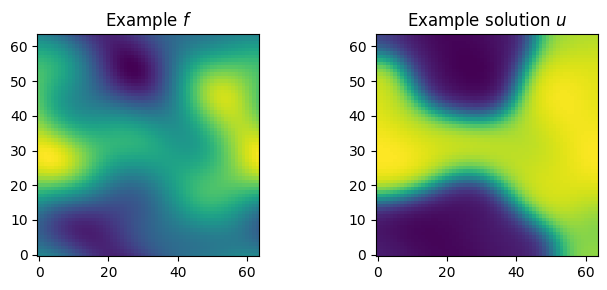

In [17]:
# Plot one example of the data
f, axarr = plt.subplots(1, 2, figsize=(7, 3))
plot_idx = 0
axarr[0].imshow(input_f[plot_idx, :, :], origin='lower')
axarr[0].title.set_text(r"Example $f$")
axarr[1].imshow(output_u[plot_idx, :, :], origin='lower')
axarr[1].title.set_text(r"Example solution $u$")
plt.tight_layout()

In [18]:
X = tp.spaces.R2("x")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")

fn_space_F = tp.spaces.FunctionSpace(X, F)
fn_space_U = tp.spaces.FunctionSpace(X, U)

In [19]:
# Split data into training and testing:
total_data = len(input_f)
train_N = int(0.9*total_data)

train_f = input_f[:train_N]
train_u = output_u[:train_N]

test_f = input_f[train_N:]
test_u = output_u[train_N:]

# Define FunctionSet, here now switched to roles of u and f!!!
data_functionset_input = tp.domains.DataFunctionSet(fn_space_U, train_u)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_F, train_f)

In [20]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(4000, data_functionset_input)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

In [21]:
data_functionset_input.compute_pca(components=100)
data_functionset_output.compute_pca(components=300)

model = tp.models.PCANN_FC.from_fn_set(
    data_functionset_input, data_functionset_output, hidden=(100, 180, 250)
)

In [22]:
data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

In [23]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 3000, "gamma":0.25})
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=20000, 
                    logger=False, 
                    enable_checkpointing=False)

trainer.fit(solver)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 148 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
148 K     Trainable params
0         Non-trainable params
148 K     Total params
0.595     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 20000/20000 [02:04<00:00, 161.16it/s, train/loss=0.0281]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|██████████| 20000/20000 [02:04<00:00, 161.16it/s, train/loss=0.0281]


In [26]:
model_output = model(tp.spaces.Points(test_u, U)).as_tensor.detach()

rel_error = torch.max(torch.abs(model_output - test_f)) / torch.max(test_f)

print(f"Relative error: {rel_error*100} %")


Relative error: 57.277679443359375 %


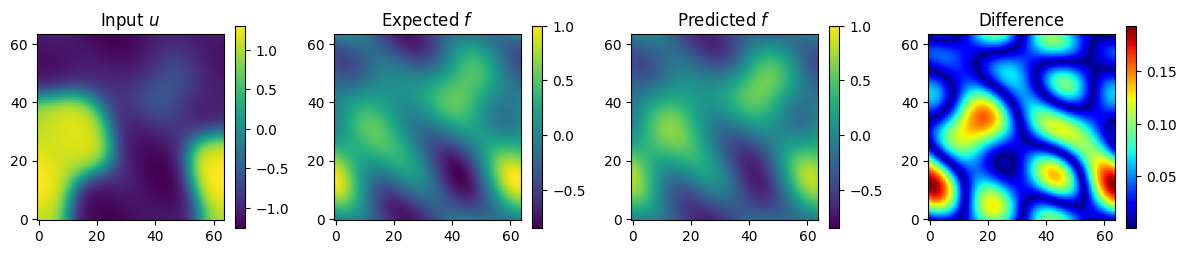

In [27]:
# Plot one example of the test data
plot_idx = 1

f, axarr = plt.subplots(1, 4, figsize=(12, 3))

vmin, vmax = torch.min(test_f[plot_idx]), torch.max(test_f[plot_idx])

img = axarr[0].imshow(test_u[plot_idx, :, :], origin='lower')
axarr[0].title.set_text(r"Input $u$")
plt.colorbar(img, ax=axarr[0], shrink=0.75)

img=axarr[1].imshow(test_f[plot_idx, :, :], vmin=vmin, vmax=vmax, origin='lower')
axarr[1].title.set_text(r"Expected $f$")
plt.colorbar(img, ax=axarr[1], shrink=0.75)

img=axarr[2].imshow(model_output[plot_idx, :, :], vmin=vmin, vmax=vmax, origin='lower')
axarr[2].title.set_text(r"Predicted $f$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)

img=axarr[3].imshow(torch.abs(model_output[plot_idx, :, :]-test_f[plot_idx, :, :]), 
                cmap="jet", origin='lower')
axarr[3].title.set_text(r"Difference")
plt.colorbar(img, ax=axarr[3], shrink=0.75)

plt.tight_layout()